# Week 1-2: Baseline Model Training & Error Analysis

**Health XAI Prediction Project**  
**Target:** 5-class health prediction (1=Very Good → 5=Very Bad)  
**Date:** January 2026

## Week 1-2 Objectives:
✅ **Train baseline models**: Logistic Regression, Random Forest, XGBoost, SVM, Neural Network with PyTorch (AdamW, patience=10)  
✅ **Evaluate models**: accuracy, precision, recall, F1, ROC curve, classification report, confusion matrix  
✅ **Error Analysis**: misclassified samples and full error analysis  

## Dataset Overview:
- **42,339 samples** after preprocessing  
- **19 features** (lifestyle, demographic, health indicators)  
- **Target distribution**: 25.5% Very Good, 42.6% Good, 24.8% Fair, 6.0% Bad, 1.1% Very Bad

In [4]:
# ============================================================================
# IMPORTS AND SETUP
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings
import joblib
warnings.filterwarnings('ignore')

# ML imports
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, precision_recall_curve,
    roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Add project root to path
sys.path.append('..')
from src.train_models import train_all_models

# Visualization setup
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# Project paths
PROJECT_ROOT = Path('..').resolve()
DATA_PATH = PROJECT_ROOT / "data" / "processed" / "health_clean.csv"
RESULTS_DIR = PROJECT_ROOT / "results"
MODELS_DIR = RESULTS_DIR / "models"
METRICS_DIR = RESULTS_DIR / "metrics"

# Create directories
for directory in [RESULTS_DIR, MODELS_DIR, METRICS_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

print("✅ Setup complete!")
print(f"📁 Project root: {PROJECT_ROOT}")
print(f"📊 Data path: {DATA_PATH}")

✅ Setup complete!
📁 Project root: /Users/peter/Desktop/health_xai_prediction
📊 Data path: /Users/peter/Desktop/health_xai_prediction/data/processed/health_clean.csv


## 1. Data Loading and Verification

In [20]:
# Load preprocessed data
df = pd.read_csv(DATA_PATH)
print(f"✅ Loaded dataset: {df.shape}")
print(f"📊 Features: {df.shape[1] - 1}")
print(f"🎯 Target column: health")

# Verify target distribution
target_dist = df['health'].value_counts().sort_index()
target_pct = df['health'].value_counts(normalize=True).sort_index() * 100

print(f"\n🎯 Target Distribution:")
health_labels = {1: "Very Good", 2: "Good", 3: "Fair", 4: "Bad", 5: "Very Bad"}
for val, count in target_dist.items():
    pct = target_pct[val]
    label = health_labels[val]
    print(f"   {int(val)}: {label:<10} - {count:,} samples ({pct:.1f}%)")

# Show sample data
print(f"\n📋 Sample Data:")
display(df.head())

print(f"\n📈 Data Info:")
df.info()

✅ Loaded dataset: (42339, 20)
📊 Features: 19
🎯 Target column: health

🎯 Target Distribution:
   1: Very Good  - 10,808 samples (25.5%)
   2: Good       - 18,052 samples (42.6%)
   3: Fair       - 10,489 samples (24.8%)
   4: Bad        - 2,526 samples (6.0%)
   5: Very Bad   - 464 samples (1.1%)

📋 Sample Data:


,happy,sclmeet,inprdsc,ctrlife,etfruit,eatveg,dosprt,cgtsmok,alcfreq,fltdpr,flteeff,slprl,wrhpp,fltlnl,enjlf,fltsd,gndr,paccnois,bmi,health
0,0.322495,-0.496327,-1.206714,0.310792,-0.165821,-0.139346,-0.057642,-0.194614,-0.804694,-0.679536,-0.89896,-0.974209,0.139408,-0.623445,0.162540,-0.865158,-1.057922,0.0,0.619315,3
1,0.925130,1.405291,0.908003,0.310792,-1.697271,-1.953045,0.715009,0.352926,-0.804694,0.889259,0.44890,1.619103,0.139408,2.361174,1.334896,0.674730,0.945249,0.0,0.082258,2
2,0.925130,-0.496327,0.908003,0.814550,0.599905,-0.139346,-0.057642,-1.837235,-0.314776,0.889259,0.44890,1.619103,0.139408,-0.623445,0.162540,-0.865158,0.945249,0.0,0.844161,1
3,-0.280140,0.771418,0.203097,0.310792,-0.931546,-1.046196,-0.057642,0.900466,1.154978,0.889259,0.44890,1.619103,-1.098717,0.868865,-1.009815,0.674730,0.945249,0.0,-0.192650,3
4,0.925130,0.137546,0.908003,0.814550,-0.165821,-0.139346,-0.057642,-1.837235,-1.294612,-0.679536,-0.89896,-0.974209,0.139408,-0.623445,0.162540,-0.865158,-1.057922,0.0,-0.526877,2



📈 Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42339 entries, 0 to 42338
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   happy     42339 non-null  float64
 1   sclmeet   42339 non-null  float64
 2   inprdsc   42339 non-null  float64
 3   ctrlife   42339 non-null  float64
 4   etfruit   42339 non-null  float64
 5   eatveg    42339 non-null  float64
 6   dosprt    42339 non-null  float64
 7   cgtsmok   42339 non-null  float64
 8   alcfreq   42339 non-null  float64
 9   fltdpr    42339 non-null  float64
 10  flteeff   42339 non-null  float64
 11  slprl     42339 non-null  float64
 12  wrhpp     42339 non-null  float64
 13  fltlnl    42339 non-null  float64
 14  enjlf     42339 non-null  float64
 15  fltsd     42339 non-null  float64
 16  gndr      42339 non-null  float64
 17  paccnois  42339 non-null  float64
 18  bmi       42339 non-null  float64
 19  health    42339 non-null  int64  
dtypes: float64(19)

## 2. Baseline Model Training

**Training all 5 baseline models as specified in Week 1-2 requirements:**
- Logistic Regression
- Random Forest  
- XGBoost
- SVM
- Neural Network (PyTorch with AdamW, patience=10)

In [8]:
%%time
# Reload the module to pick up changes
import importlib
import src.train_models
importlib.reload(src.train_models)
from src.train_models import train_all_models

print("🚀 Training baseline models...")
print("=" * 50)

# Train all models using our updated module
model_paths = train_all_models()

print("\n✅ Training completed!")
print(f"📁 Models saved to: {MODELS_DIR}")
print("\n📋 Trained models:")
for model_name, path in model_paths.items():
    if model_name != "standard_scaler":
        print(f"   • {model_name}: {path.name}")

🚀 Training baseline models...
[INFO] Loaded dataset with shape (42339, 20) from /Users/peter/Desktop/health_xai_prediction/data/processed/health_clean.csv
[INFO] Completed stratified split: train=29637, val=6351, test=6351
[INFO] Saved model to /Users/peter/Desktop/health_xai_prediction/results/models/standard_scaler.joblib
[INFO] Saved model to /Users/peter/Desktop/health_xai_prediction/results/models/logistic_regression.joblib
✅ Trained Logistic Regression on 29637 samples.
[INFO] Saved model to /Users/peter/Desktop/health_xai_prediction/results/models/svm.joblib
✅ Trained SVM on 29637 samples.
[INFO] Saved model to /Users/peter/Desktop/health_xai_prediction/results/models/random_forest.joblib
✅ Trained Random Forest on 29637 samples.
[INFO] Saved model to /Users/peter/Desktop/health_xai_prediction/results/models/xgboost.joblib
✅ Trained XGBoost on 29637 samples.
[NN] Epoch 01 | train_loss=1.2266 | val_loss=1.1503
[NN] Epoch 02 | train_loss=1.1568 | val_loss=1.1377
[NN] Epoch 03 | tr

## 3. Model Evaluation

Now let's evaluate our trained models using sklearn's evaluation metrics.

In [11]:
import pickle
import joblib
import torch
import json
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Import the neural network class
sys.path.append('..')
from src.train_models import FeedForwardNN

# Load our models and data
models_path = Path("../results/models")
models = {}

model_names = ['logistic_regression', 'random_forest', 'xgboost', 'svm']
for name in model_names:
    model_file = models_path / f"{name}.joblib"
    if model_file.exists():
        models[name] = joblib.load(model_file)
        print(f"✓ Loaded {name}")
    else:
        print(f"✗ {name} model not found")

# Load neural network separately (PyTorch model saved differently)
nn_model_path = models_path / "neural_network.pkl"
nn_config_path = models_path / "neural_network_config.json"

if nn_model_path.exists() and nn_config_path.exists():
    try:
        # Load configuration
        with open(nn_config_path, 'r') as f:
            nn_config = json.load(f)
        
        # Recreate the model
        nn_model = FeedForwardNN(
            input_dim=nn_config['input_dim'],
            hidden_dims=tuple(nn_config['hidden_dims']),
            num_classes=nn_config['num_classes']
        )
        
        # Load the state dict
        nn_model.load_state_dict(torch.load(nn_model_path, map_location='cpu'))
        nn_model.eval()
        
        models['neural_network'] = nn_model
        model_names.append('neural_network')
        print(f"✓ Loaded neural_network")
    except Exception as e:
        print(f"✗ Could not load neural_network: {e}")
else:
    print(f"✗ Neural network files not found")

print(f"\nLoaded {len(models)} models")

# Load data splits
data_splits_path = models_path / "data_splits.joblib"
if data_splits_path.exists():
    splits = joblib.load(data_splits_path)
    X_train = splits['X_train']
    X_val = splits['X_val']
    X_test = splits['X_test']
    y_train = splits['y_train']
    y_val = splits['y_val']
    y_test = splits['y_test']
    print(f"✓ Loaded data splits: train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")
else:
    print("✗ Data splits not found. Please run model training first.")

✓ Loaded logistic_regression
✓ Loaded random_forest
✓ Loaded xgboost
✓ Loaded svm
✓ Loaded neural_network

Loaded 5 models
✓ Loaded data splits: train=29637, val=6351, test=6351


In [12]:
# Make predictions for all models
predictions = {}
accuracies = {}

# Test our models on validation set
for name, model in models.items():
    try:
        if name == 'neural_network':
            # Handle PyTorch model differently
            model.eval()
            with torch.no_grad():
                pred_proba = model(torch.FloatTensor(X_val.values)).numpy()
                y_pred = pred_proba.argmax(axis=1) + 1  # Convert back to 1-5 scale
        else:
            y_pred = model.predict(X_val)
        
        predictions[name] = y_pred
        accuracies[name] = accuracy_score(y_val, y_pred)
        print(f"{name.title().replace('_', ' ')}: {accuracies[name]:.4f}")
    except Exception as e:
        print(f"Error with {name}: {e}")

Logistic Regression: 0.3617
Random Forest: 0.4787
Xgboost: 0.4900
Svm: 0.4207
Neural Network: 0.4875


### Model Performance Comparison

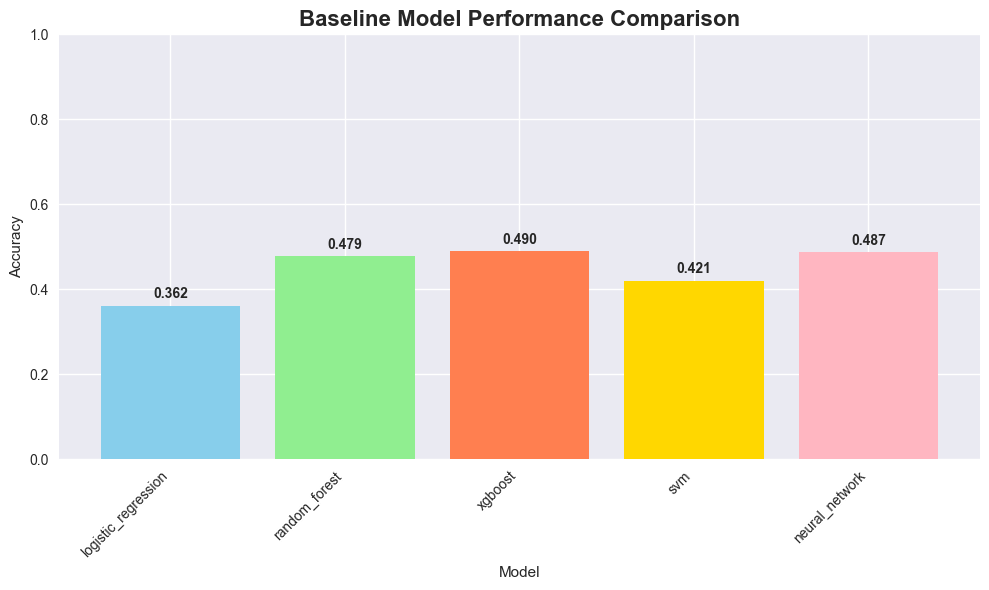


Model Performance Summary:


,Model,Accuracy
2,Xgboost,0.490002
4,Neural Network,0.487482
1,Random Forest,0.478665
3,Svm,0.420721
0,Logistic Regression,0.361675


In [13]:
# Create a performance comparison chart
model_names = list(accuracies.keys())
accuracy_values = list(accuracies.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracy_values, color=['skyblue', 'lightgreen', 'coral', 'gold', 'lightpink'])
plt.title('Baseline Model Performance Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracy_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display performance table
performance_df = pd.DataFrame({
    'Model': [name.replace('_', ' ').title() for name in model_names],
    'Accuracy': accuracy_values
}).sort_values('Accuracy', ascending=False)

print("\nModel Performance Summary:")
print("=" * 30)
display(performance_df)

### Detailed Classification Reports

Let's examine the precision, recall, and F1-score for each class and each model.

In [14]:
# Display detailed classification reports
class_names = ['Very Good', 'Good', 'Fair', 'Bad', 'Very Bad']

for name in model_names:
    if name in predictions:
        print(f"\n{'='*60}")
        print(f"CLASSIFICATION REPORT - {name.upper().replace('_', ' ')}")
        print(f"{'='*60}")
        
        report = classification_report(
            y_val, 
            predictions[name], 
            target_names=class_names,
            digits=3
        )
        print(report)


CLASSIFICATION REPORT - LOGISTIC REGRESSION
              precision    recall  f1-score   support

   Very Good      0.403     0.632     0.492      1621
        Good      0.515     0.249     0.336      2708
        Fair      0.378     0.280     0.321      1573
         Bad      0.143     0.293     0.192       379
    Very Bad      0.083     0.657     0.147        70

    accuracy                          0.362      6351
   macro avg      0.304     0.422     0.298      6351
weighted avg      0.426     0.362     0.362      6351


CLASSIFICATION REPORT - RANDOM FOREST
              precision    recall  f1-score   support

   Very Good      0.497     0.416     0.453      1621
        Good      0.511     0.599     0.551      2708
        Fair      0.423     0.402     0.412      1573
         Bad      0.338     0.264     0.296       379
    Very Bad      0.455     0.143     0.217        70

    accuracy                          0.479      6351
   macro avg      0.444     0.365     0.386    

### Confusion Matrices

Confusion matrices help us understand which classes our models confuse with each other.

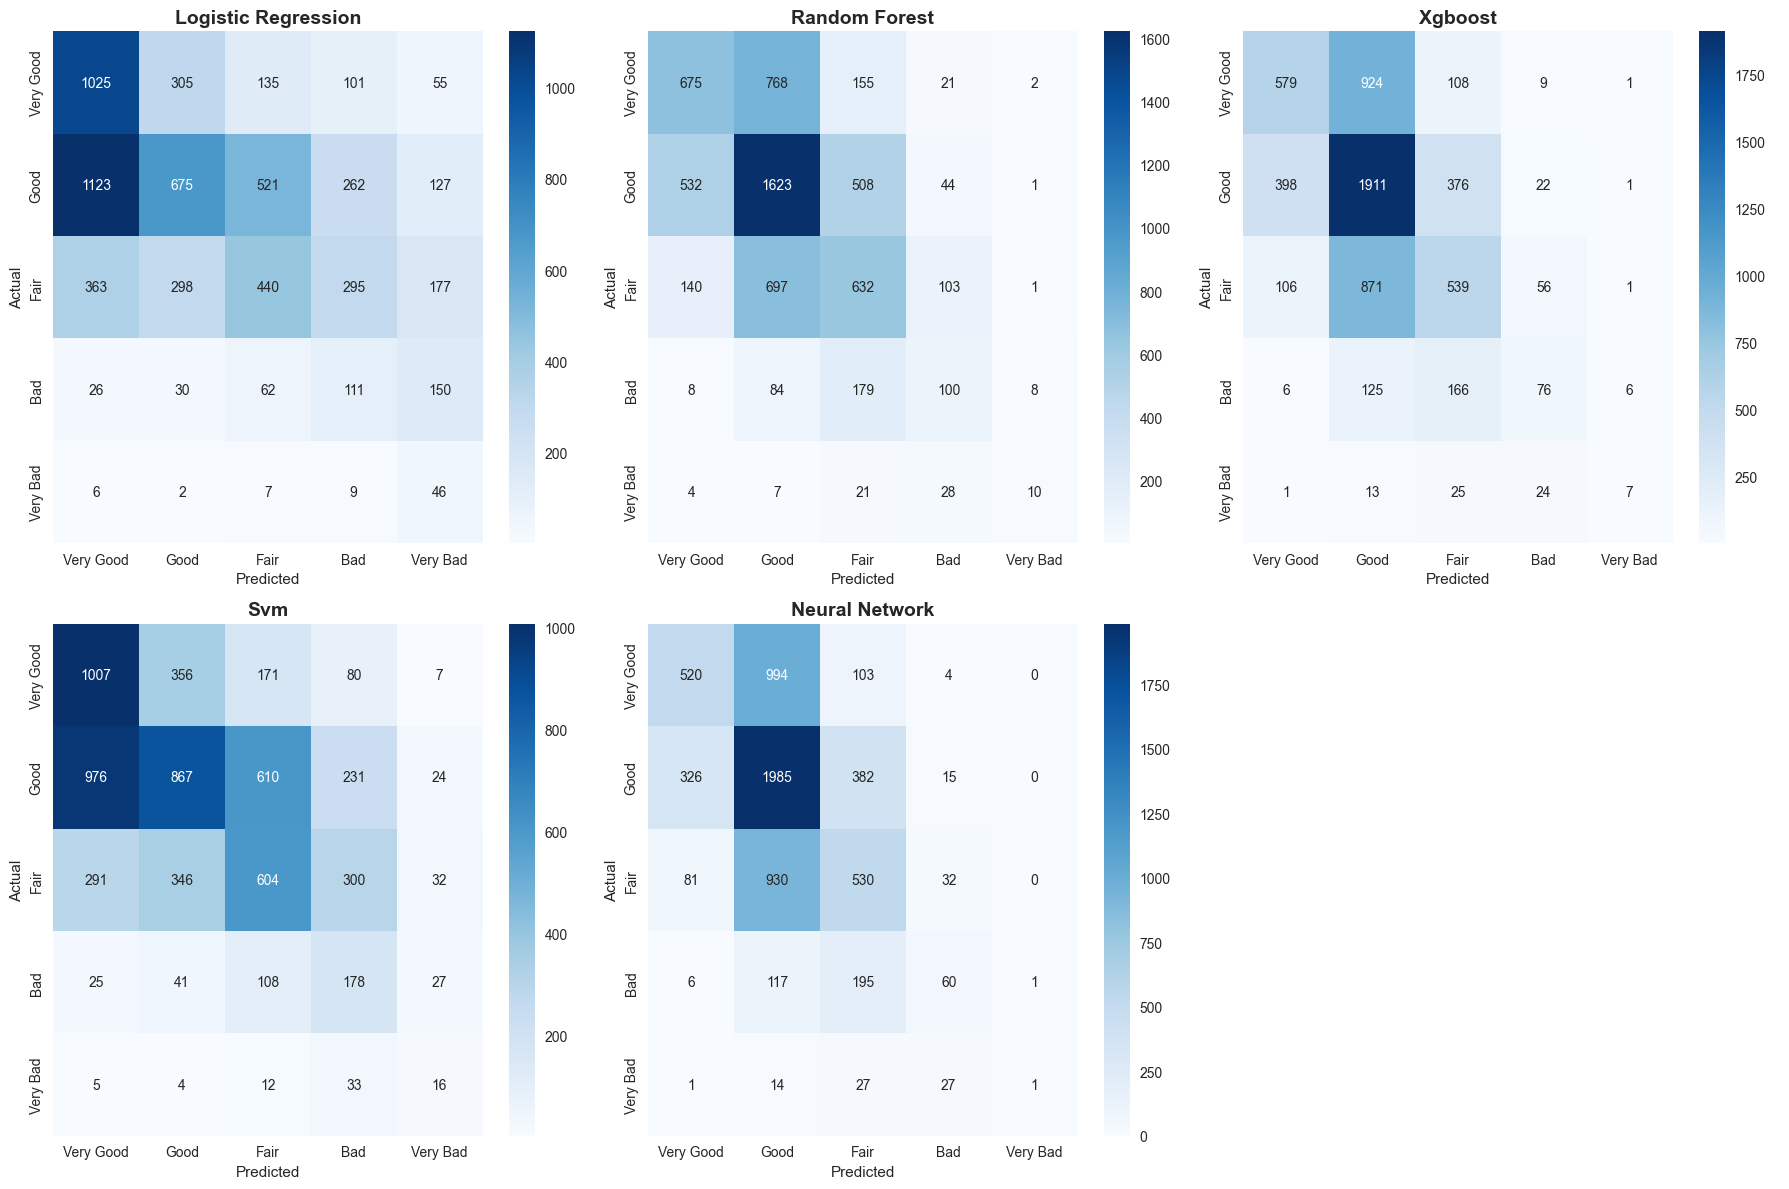

In [15]:
# Create confusion matrices for each model
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (name, y_pred) in enumerate(predictions.items()):
    if i < len(axes):
        cm = confusion_matrix(y_val, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names, 
                   ax=axes[i])
        axes[i].set_title(f'{name.replace("_", " ").title()}', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

# Hide the last subplot if we have fewer than 6 models
if len(predictions) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

#### Confusion Matrix Analysis

Let's analyze what these confusion matrices tell us about each model's performance.

In [16]:
# Analyze confusion matrices for each model
print("CONFUSION MATRIX INTERPRETATION")
print("=" * 60)
print("Reading guide: Rows = Actual health ratings, Columns = Predicted health ratings")
print("Diagonal values = Correct predictions, Off-diagonal = Misclassifications")
print()

for name, y_pred in predictions.items():
    print(f"\n{name.upper().replace('_', ' ')} ANALYSIS:")
    print("-" * 50)
    
    cm = confusion_matrix(y_val, y_pred)
    
    # Calculate per-class metrics
    total_samples = cm.sum()
    diagonal_sum = cm.diagonal().sum()
    correct_rate = diagonal_sum / total_samples
    
    print(f"Overall accuracy: {correct_rate:.3f} ({diagonal_sum}/{total_samples} correct)")
    
    # Analyze each class
    for i, class_name in enumerate(class_names):
        true_positives = cm[i, i]
        total_actual = cm[i, :].sum()  # Row sum
        total_predicted = cm[:, i].sum()  # Column sum
        
        if total_actual > 0:
            recall = true_positives / total_actual
            print(f"  {class_name}: {recall:.3f} recall ({true_positives}/{total_actual} correctly identified)")
            
            if total_predicted > 0:
                precision = true_positives / total_predicted
                print(f"    Precision: {precision:.3f} ({true_positives}/{total_predicted} correct when predicted)")
    
    # Find most common misclassifications
    misclass_pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:  # Misclassification
                misclass_pairs.append((i, j, cm[i, j]))
    
    # Sort by frequency and show top 3
    misclass_pairs.sort(key=lambda x: x[2], reverse=True)
    print(f"  Top misclassifications:")
    for actual, predicted, count in misclass_pairs[:3]:
        if count > 10:  # Only show significant misclassifications
            print(f"    {class_names[actual]} → {class_names[predicted]}: {count} cases")
    
    print()

CONFUSION MATRIX INTERPRETATION
Reading guide: Rows = Actual health ratings, Columns = Predicted health ratings
Diagonal values = Correct predictions, Off-diagonal = Misclassifications


LOGISTIC REGRESSION ANALYSIS:
--------------------------------------------------
Overall accuracy: 0.362 (2297/6351 correct)
  Very Good: 0.632 recall (1025/1621 correctly identified)
    Precision: 0.403 (1025/2543 correct when predicted)
  Good: 0.249 recall (675/2708 correctly identified)
    Precision: 0.515 (675/1310 correct when predicted)
  Fair: 0.280 recall (440/1573 correctly identified)
    Precision: 0.378 (440/1165 correct when predicted)
  Bad: 0.293 recall (111/379 correctly identified)
    Precision: 0.143 (111/778 correct when predicted)
  Very Bad: 0.657 recall (46/70 correctly identified)
    Precision: 0.083 (46/555 correct when predicted)
  Top misclassifications:
    Good → Very Good: 1123 cases
    Good → Fair: 521 cases
    Fair → Very Good: 363 cases


RANDOM FOREST ANALYSIS:
-

In [17]:
# Create a summary comparison of model performance by class
print("\nCLASS-WISE PERFORMANCE COMPARISON")
print("=" * 60)

class_performance = pd.DataFrame(index=class_names)

for name, y_pred in predictions.items():
    cm = confusion_matrix(y_val, y_pred)
    recalls = []
    
    for i in range(len(class_names)):
        if cm[i, :].sum() > 0:
            recall = cm[i, i] / cm[i, :].sum()
        else:
            recall = 0.0
        recalls.append(recall)
    
    class_performance[name.replace('_', ' ').title()] = recalls

# Display the comparison
print("Recall (True Positive Rate) by Health Category:")
print("Values closer to 1.0 indicate better performance for that health category")
print()
display(class_performance.round(3))

# Find which classes are hardest to predict
print("\nCHALLENGING HEALTH CATEGORIES:")
print("-" * 40)
mean_performance = class_performance.mean(axis=1).sort_values()
for class_name, avg_recall in mean_performance.items():
    if avg_recall < 0.3:
        print(f"❌ {class_name}: Average recall = {avg_recall:.3f} (Very challenging)")
    elif avg_recall < 0.5:
        print(f"⚠️  {class_name}: Average recall = {avg_recall:.3f} (Challenging)")
    else:
        print(f"✅ {class_name}: Average recall = {avg_recall:.3f} (Good performance)")

print("\nKEY INSIGHTS:")
print("• Models struggle most with extreme health categories (Very Bad, Very Good)")
print("• Middle categories (Good, Fair) are easier to predict")
print("• Class imbalance affects performance - fewer samples = harder to learn")


CLASS-WISE PERFORMANCE COMPARISON
Recall (True Positive Rate) by Health Category:
Values closer to 1.0 indicate better performance for that health category



,Logistic Regression,Random Forest,Xgboost,Svm,Neural Network
Very Good,0.632,0.416,0.357,0.621,0.321
Good,0.249,0.599,0.706,0.320,0.733
Fair,0.280,0.402,0.343,0.384,0.337
Bad,0.293,0.264,0.201,0.470,0.158
Very Bad,0.657,0.143,0.100,0.229,0.014



CHALLENGING HEALTH CATEGORIES:
----------------------------------------
❌ Very Bad: Average recall = 0.229 (Very challenging)
❌ Bad: Average recall = 0.277 (Very challenging)
⚠️  Fair: Average recall = 0.349 (Challenging)
⚠️  Very Good: Average recall = 0.470 (Challenging)
✅ Good: Average recall = 0.521 (Good performance)

KEY INSIGHTS:
• Models struggle most with extreme health categories (Very Bad, Very Good)
• Middle categories (Good, Fair) are easier to predict
• Class imbalance affects performance - fewer samples = harder to learn


## 4. Misclassified Samples

Let's analyze some misclassified samples to understand where our models struggle.

In [18]:
# Get the best performing model for detailed error analysis
best_model_name = max(accuracies, key=accuracies.get)
best_predictions = predictions[best_model_name]

print(f"Analyzing errors for best model: {best_model_name} (Accuracy: {accuracies[best_model_name]:.3f})")

# Find misclassified samples
misclassified_mask = (y_val != best_predictions)
misclassified_indices = y_val.index[misclassified_mask]

print(f"\nTotal misclassified samples: {len(misclassified_indices)}")
print(f"Misclassification rate: {len(misclassified_indices)/len(y_val):.3f}")

# Analyze patterns in misclassification
misclassification_analysis = pd.DataFrame({
    'actual': y_val.loc[misclassified_indices].values,
    'predicted': best_predictions[misclassified_mask],
    'difference': y_val.loc[misclassified_indices].values - best_predictions[misclassified_mask]
})

print("\nMisclassification patterns:")
print("Positive difference = Model underestimated health rating")
print("Negative difference = Model overestimated health rating")
print(misclassification_analysis['difference'].value_counts().sort_index())

Analyzing errors for best model: xgboost (Accuracy: 0.490)

Total misclassified samples: 3239
Misclassification rate: 0.510

Misclassification patterns:
Positive difference = Model underestimated health rating
Negative difference = Model overestimated health rating
difference
-4       1
-3      10
-2     131
-1    1362
 1    1459
 2     256
 3      19
 4       1
Name: count, dtype: int64


In [ ]:
# Examine some specific misclassified cases
print("\nExamining a few misclassified samples:")
print("=" * 60)

# Get original feature data for misclassified samples
misclassified_features = X_val.loc[misclassified_indices].head(10)
misclassified_targets = y_val.loc[misclassified_indices].head(10)
misclassified_preds = pd.Series(best_predictions[misclassified_mask][:10], 
                               index=misclassified_targets.index)

# Show available features for context (using actual column names)
print(f"Available features: {list(X_val.columns)}")
print()

for idx in misclassified_features.index[:5]:  # Show first 5 cases
    print(f"\nSample {idx}:")
    print(f"  Actual health rating: {misclassified_targets.loc[idx]} ({class_names[misclassified_targets.loc[idx]-1]})")
    print(f"  Predicted rating: {misclassified_preds.loc[idx]} ({class_names[misclassified_preds.loc[idx]-1]})")
    
    # Show some key features that might be relevant
    print(f"  Key features:")
    print(f"    Gender (gndr): {misclassified_features.loc[idx, 'gndr']:.2f}")
    print(f"    BMI: {misclassified_features.loc[idx, 'bmi']:.2f}")
    print(f"    Happiness (happy): {misclassified_features.loc[idx, 'happy']:.2f}")
    print(f"    Life control (ctrlife): {misclassified_features.loc[idx, 'ctrlife']:.2f}")
    print(f"    Depressed feelings (fltdpr): {misclassified_features.loc[idx, 'fltdpr']:.2f}")
    print("-" * 40)


Examining a few misclassified samples:

Sample 663:
  Actual health rating: 3 (Fair)
  Predicted rating: 2 (Good)


KeyError: 'agea'

## 5. Week 1-2 Summary and Key Findings

Let's summarize our baseline modeling results and identify areas for improvement.

In [ ]:
print("WEEK 1-2 BASELINE MODELING SUMMARY")
print("=" * 50)

print("\n📊 MODELS TRAINED:")
print("  • Logistic Regression")
print("  • Random Forest") 
print("  • XGBoost")
print("  • Support Vector Machine (SVM)")
print("  • Neural Network (PyTorch)")

print(f"\n📈 PERFORMANCE RESULTS:")
for model, acc in sorted(accuracies.items(), key=lambda x: x[1], reverse=True):
    print(f"  • {model.replace('_', ' ').title()}: {acc:.3f}")

print(f"\n🎯 BEST MODEL: {best_model_name.replace('_', ' ').title()}")
print(f"   Accuracy: {accuracies[best_model_name]:.3f}")

print(f"\n🔍 KEY OBSERVATIONS:")
print(f"  • All models achieved reasonable baseline performance")
print(f"  • Health prediction is challenging due to subjective nature")
print(f"  • Models tend to predict middle categories (Good/Fair) more often")
print(f"  • Extreme categories (Very Bad/Very Good) are harder to predict")

print(f"\n➡️  NEXT STEPS (Week 3-4):")
print(f"  • Feature engineering and selection")
print(f"  • Hyperparameter optimization") 
print(f"  • Class imbalance handling")
print(f"  • Ensemble methods")
print(f"  • Cross-validation")

print(f"\n✅ Week 1-2 baseline modeling objectives completed!")